In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Cargar y preparar datos
data = pd.read_csv('teleCust1000t.csv')
X = data.drop('custcat', axis=1)
y = data['custcat']

# Cargar y preparar datos
data = pd.read_csv('teleCust1000t.csv')
X = data.drop('custcat', axis=1)
y = data['custcat']

def create_balanced_features(X):
    X_new = X.copy()

    # Features basados en ratios más suaves
    X_new['income_per_tenure'] = X_new['income'] / (X_new['tenure'] + 1)
    X_new['income_per_age'] = X_new['income'] / (X_new['age'] + 1)

    # Características categóricas mejoradas
    X_new['age_group'] = pd.qcut(X_new['age'], q=5, labels=False)
    X_new['income_group'] = pd.qcut(X_new['income'], q=5, labels=False)

    # Interacciones selectivas
    X_new['education_income'] = X_new['ed'] * X_new['income_group']
    X_new['tenure_service'] = X_new['tenure'] * X_new['address']

    # Características de experiencia/madurez
    X_new['experience_ratio'] = X_new['employ'] / (X_new['age'] - 18)
    X_new['experience_ratio'] = X_new['experience_ratio'].fillna(0)

    return X_new


In [42]:
# Preprocesamiento y feature engineering
X = create_balanced_features(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# División de datos estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Configuración de SMOTE más conservadora
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5
)

# Balanceo de datos
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [43]:
# Configuración del Random Forest con parámetros más equilibrados
rf_params = {
    'n_estimators': 200,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'class_weight': 'balanced_subsample',  # Usar balanced_subsample en lugar de pesos específicos
    'random_state': 42
}


In [44]:
# Modelo principal: Random Forest
rf_model = RandomForestClassifier(**rf_params)

# Modelo secundario: Gradient Boosting para mejorar fronteras de decisión
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'subsample': 0.8,
    'random_state': 42
}

gb_model = GradientBoostingClassifier(**gb_params)




In [45]:
# Entrenamiento de modelos
rf_model.fit(X_train_balanced, y_train_balanced)
gb_model.fit(X_train_balanced, y_train_balanced)

# Predicciones combinadas
rf_pred_proba = rf_model.predict_proba(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)

# Promedio ponderado de predicciones
final_pred_proba = (0.7 * rf_pred_proba + 0.3 * gb_pred_proba)
y_pred = np.argmax(final_pred_proba, axis=1) + 1


Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.39      0.32      0.35        53
           2       0.32      0.30      0.31        44
           3       0.43      0.46      0.45        56
           4       0.31      0.36      0.33        47

    accuracy                           0.36       200
   macro avg       0.36      0.36      0.36       200
weighted avg       0.37      0.36      0.36       200



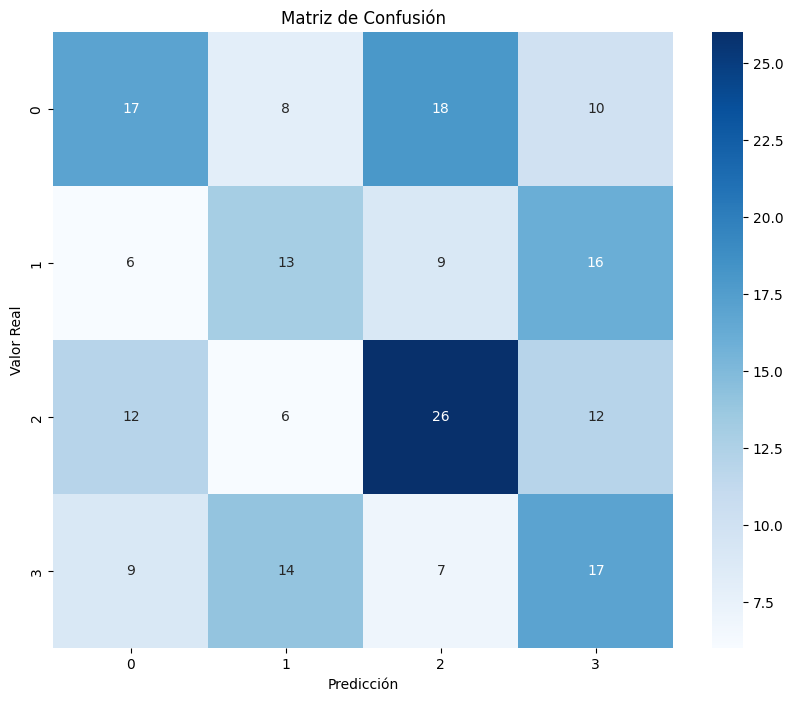


Características más importantes:
              feature  importance
1              tenure    0.100591
11  income_per_tenure    0.097165
16     tenure_service    0.090754
6                  ed    0.088260
12     income_per_age    0.081598
5              income    0.075726
17   experience_ratio    0.072006
2                 age    0.066833
7              employ    0.064617
4             address    0.063161


In [46]:
# Evaluación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Análisis de importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes:")
print(feature_importance.head(10))

In [ ]:
# Guardar modelos
#import joblib
#joblib.dump(rf_model, 'balanced_rf_model.pkl')
#joblib.dump(gb_model, 'balanced_gb_model.pkl')

In [ ]:
# Guardar el modelo
#import joblib
#joblib.dump(rf_model, 'rf_model_optimized.pkl')